In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, optim

from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import tqdm

In [2]:
target_raw_1 = np.load('vel2_1_0.npy')
target_raw_2 = np.load('vel4_1_0.npy')
target_raw_3 = np.load('vel6_1_0.npy')
target_raw_4 = np.load('vel8_1_0.npy')
target_raw = np.concatenate([target_raw_1, target_raw_2, target_raw_3, target_raw_4], axis=0).reshape((-1,70,70))
target_scaled = (target_raw - target_raw.min())/(target_raw.max() - target_raw.min())

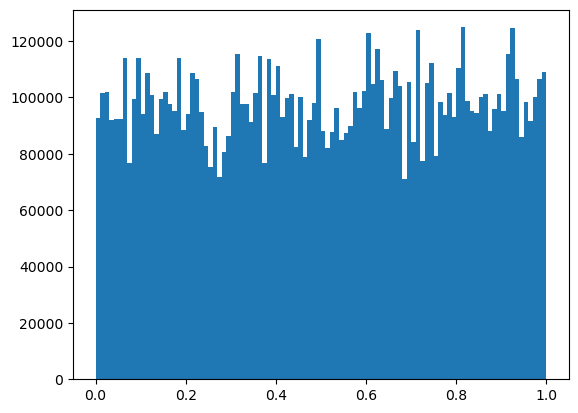

In [3]:
plt.hist(target_scaled.flatten(), bins=100);

In [4]:
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(70 * 70, 2048),
            #nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            #nn.ReLU(),
            #nn.Linear(128, 64)
        )
        self.decoder = nn.Sequential(
            #nn.Linear(64, 128),
            #nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 2048),
            nn.ReLU(),
            nn.Linear(2048, 70 * 70),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [5]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            #nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            #nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            #nn.MaxPool2d(kernel_size=2, stride=2)
        )

    def forward(self, x):
        x = self.encoder(x)
        return x

        
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            #nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            #nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            #nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            #nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=1, padding=1),
            #nn.ReLU(),
            #nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            #nn.ReLU(),
            #nn.Conv2d(32, 1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.decoder(x)
        return x


class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [6]:
class CNNAutoencoder(nn.Module):
    def __init__(self, latent_dim=64):
        super(CNNAutoencoder, self).__init__()
        
        # Encoder
        k1 = 4
        k2 = 8
        k3 = 16
        k4 = 32
        self.encoder = nn.Sequential(
            # First convolutional block
            nn.Conv2d(1, k1, kernel_size=3, stride=2, padding=1),  # 70x70 -> 35x35
            nn.BatchNorm2d(k1),
            nn.ReLU(True),
            
            # Second convolutional block
            nn.Conv2d(k1, k2, kernel_size=3, stride=2, padding=1),  # 35x35 -> 18x18
            nn.BatchNorm2d(k2),
            nn.ReLU(True),
            
            # Third convolutional block
            nn.Conv2d(k2, k3, kernel_size=3, stride=2, padding=1),  # 18x18 -> 9x9
            nn.BatchNorm2d(k3),
            nn.ReLU(True),
            
            # Final encoding layer
            nn.Conv2d(k3, k4, kernel_size=3, stride=1, padding=1),  # 9x9 -> 9x9
            nn.BatchNorm2d(k4),
            nn.ReLU(True),

            nn.Flatten(),
            
            nn.Linear(k4*9*9, latent_dim),
            #nn.BatchNorm1d(latent_dim),
            nn.ReLU(True),
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, k4*9*9),
            #nn.BatchNorm1d(k4*9*9),
            nn.ReLU(True),
            
            nn.Unflatten(1, (k4,9,9)),
            
            # First transposed conv block
            nn.ConvTranspose2d(k4, k3, kernel_size=3, stride=1, padding=1),  # 9x9 -> 9x9
            nn.BatchNorm2d(k3),
            nn.ReLU(True),
            
            # Second transposed conv block
            nn.ConvTranspose2d(k3, k2, kernel_size=3, stride=2, padding=1, output_padding=1),  # 9x9 -> 18x18
            nn.BatchNorm2d(k2),
            nn.ReLU(True),
            
            # Third transposed conv block
            nn.ConvTranspose2d(k2, k1, kernel_size=3, stride=2, padding=1),  # 18x18 -> 35x35
            nn.BatchNorm2d(k1),
            nn.ReLU(True),
            
            # Final transposed conv block
            nn.ConvTranspose2d(k1, 1, kernel_size=3, stride=2, padding=1, output_padding=1),  # 35x35 -> 70x70
            nn.Sigmoid()  # Ensures output is between 0 and 1
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def encode(self, x):
        return self.encoder(x)
    
    def decode(self, x):
        return self.decoder(x)


In [67]:
model = CNNAutoencoder(latent_dim=64)
loss_function = nn.MSELoss()
loss_function = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-8)
def verify_dimensions(model):
    print("Verifying network dimensions...")
    x = torch.randn(1, 1, 70, 70)
    
    # Check encoder dimensions
    for i, layer in enumerate(model.encoder):
        x = layer(x)
        print(f"Encoder layer {i} ({layer.__class__.__name__}): output shape = {x.shape}")
    
    # Check decoder dimensions
    for i, layer in enumerate(model.decoder):
        x = layer(x)
        print(f"Decoder layer {i} ({layer.__class__.__name__}): output shape = {x.shape}")
    
    if x.shape[2] == 70 and x.shape[3] == 70:
        print("Success! Output dimensions match input dimensions (70x70)")
    else:
        print(f"Error: Output dimensions {x.shape[2]}x{x.shape[3]} don't match expected 70x70")

verify_dimensions(model)

Verifying network dimensions...
Encoder layer 0 (Conv2d): output shape = torch.Size([1, 4, 35, 35])
Encoder layer 1 (BatchNorm2d): output shape = torch.Size([1, 4, 35, 35])
Encoder layer 2 (ReLU): output shape = torch.Size([1, 4, 35, 35])
Encoder layer 3 (Conv2d): output shape = torch.Size([1, 8, 18, 18])
Encoder layer 4 (BatchNorm2d): output shape = torch.Size([1, 8, 18, 18])
Encoder layer 5 (ReLU): output shape = torch.Size([1, 8, 18, 18])
Encoder layer 6 (Conv2d): output shape = torch.Size([1, 16, 9, 9])
Encoder layer 7 (BatchNorm2d): output shape = torch.Size([1, 16, 9, 9])
Encoder layer 8 (ReLU): output shape = torch.Size([1, 16, 9, 9])
Encoder layer 9 (Conv2d): output shape = torch.Size([1, 32, 9, 9])
Encoder layer 10 (BatchNorm2d): output shape = torch.Size([1, 32, 9, 9])
Encoder layer 11 (ReLU): output shape = torch.Size([1, 32, 9, 9])
Encoder layer 12 (Flatten): output shape = torch.Size([1, 2592])
Encoder layer 13 (Linear): output shape = torch.Size([1, 64])
Encoder layer 14 

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:22<00:00, 22.43it/s]


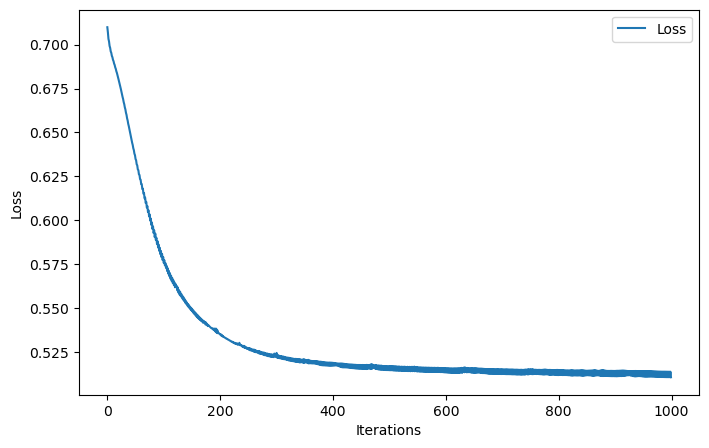

In [68]:
epochs = 500
outputs = []
losses = []
batch_size = 1024
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in tqdm.tqdm(range(epochs)):
    #for entry in target_scaled[0:700]:
    for i in range(0, int(len(target_scaled)*0.9), batch_size):
        entry = target_scaled[i:i+batch_size]
        tensor = torch.Tensor(entry.reshape(-1, 1, 70,70)).to(device)
        reconstructed = model(tensor)
        #print(reconstructed.shape)
        loss = loss_function(reconstructed, tensor)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
    
    outputs.append((epoch, entry, reconstructed))
    #print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.6f}")

#plt.style.use('fivethirtyeight')
plt.figure(figsize=(8, 5))
plt.plot(losses, label='Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

torch.Size([1, 1, 70, 70])


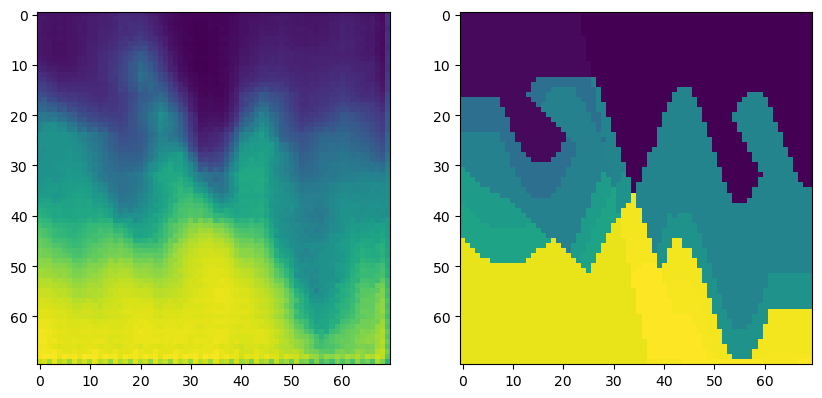

In [69]:
i = 1013
tensor = torch.Tensor(target_scaled[i].reshape(1, 1, 70,70)).to(device)
print(tensor.shape)
entry = model(tensor).detach().cpu().numpy()

fig, axs = plt.subplots(1,2, figsize=(10,5))
axs[1].imshow(target_scaled[i])
axs[0].imshow(entry.reshape(70,70))

In [70]:
target_scaled[i]

array([[0.096     , 0.096     , 0.096     , ..., 0.07566667, 0.07566667,
        0.07566667],
       [0.096     , 0.096     , 0.096     , ..., 0.07566667, 0.07566667,
        0.07566667],
       [0.096     , 0.096     , 0.096     , ..., 0.07566667, 0.07566667,
        0.07566667],
       ...,
       [0.834     , 0.834     , 0.834     , ..., 0.84833336, 0.84833336,
        0.84833336],
       [0.834     , 0.834     , 0.834     , ..., 0.84966666, 0.84966666,
        0.84966666],
       [0.834     , 0.834     , 0.834     , ..., 0.8613333 , 0.8613333 ,
        0.8613333 ]], dtype=float32)

In [71]:
entry.reshape(70,70)

array([[0.09757799, 0.0928267 , 0.08943354, ..., 0.08239056, 0.06467959,
        0.16969432],
       [0.10067733, 0.1000742 , 0.09307847, ..., 0.08312748, 0.0687298 ,
        0.17692353],
       [0.10246633, 0.09239208, 0.09235354, ..., 0.09229839, 0.07500332,
        0.17679213],
       ...,
       [0.957949  , 0.954145  , 0.9502295 , ..., 0.86879855, 0.8854319 ,
        0.7712052 ],
       [0.95689166, 0.97526985, 0.96535337, ..., 0.8957366 , 0.8809172 ,
        0.7352912 ],
       [0.8930548 , 0.9183257 , 0.847992  , ..., 0.8602903 , 0.7929835 ,
        0.63578457]], dtype=float32)